The parameters bu and bi indicate the observed deviations of user u and item i,
respectively, from the average. For example, suppose that we want a baseline
estimate for the rating of the movie Titanic by user Joe. Now, say that the
average rating over all movies, μ, is 3.7 stars. Furthermore, Titanic is better
than an average movie, so it tends to be rated 0.5 stars above the average. On
the other hand, Joe is a critical user, who tends to rate 0.3 stars lower than the
average. Thus, the baseline estimate for Titanic’s rating by Joe would be 3.9
stars by calculating 3.7 − 0.3 + 0.5. In order to estimate bu and bi one can solve
the least squares problem:

# The ultimate otaku recommender system

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import surprise as sp
import time

Referências e explicações:

[Datasets utilizados](https://www.kaggle.com/azathoth42/myanimelist/version/9#_=_)

[Bíblia](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101)

[Merges explicados](https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/)

[Gráficos explicados](http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot)

[Análises de rating](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b)

[Baseline Only](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)

This notebook presents a beginner friendly solution for a [Recommender System](https://en.wikipedia.org/wiki/Recommender_system) problem at the MyAnimeList portal. The main idea here is to understand the data presented to us, do all the cleaning and exploration stuff and then test and apply different algorithms so we have available either a User-based and an Item-based Collaborative Filtering system.

# Context and motivation

If any of you have already searched for info and rating about a Anime on the internet, you probably were sent to the [MyAnimeList](www.myanimelist.net) website. It is like the IMDB of japanese content, and has a lot of different ways for you to find something suitable to you as "Top Airing", "Top Upcoming" and so on. The score of a certain anime or manga are actually the global mean of all the ratings given by the users (I'm not quite sure about this info, but I imagine this is the case). Rates go from 0 to 10, and whenever you create your account you can score pretty much anything you want.

Ever since I've learned how [Spotify created and developed their awesome recommendation system](https://medium.com/s/story/spotifys-discover-weekly-how-machine-learning-finds-your-new-music-19a41ab76efe) I got more and more interested about how all of this stuff works in practice and started to be more curious about it. 

Now, how I connected these two stories. A while ago, I was looking for something to watch and thought "Hey, maybe I can go to MyAnimeList, give my scores of previous watched animes and maybe find something good recommended to me, kind of like Netflix and Spotify do". But since you are reading up until here, you can imagine that this is not a feature they had available in their website, which coincidentally happenned in the same time I had to think of my final project for the [Machine Learning Engineer course](https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009t) from Udacity (that I highly recommend if you have the money to spend). So hey, why not do it?

# Datasets

For the dataset, we will use the [awesome data](https://www.kaggle.com/azathoth42/myanimelist/version/9#_=_) from azazoth42 (huge thanks!). To make the cleaning data process easy, we will use only the CSVs that do not contain any null values (which have the cleaned suffix on them). 

The datasets are mainly divided in three. One with info about the MyAnimeList customers (UsersDF) such as location, gender, birth date and so on. Another one for info about the anime, which brings data like the title of the show, what genre is it inside and even the opening themes. The last one (and also the biggest one) is all the scores that a certain user had with a show (that have 31M rows of interactions, wow).

In [2]:
#Importing the CSVs to Dataframe format
UsersDF = pd.read_csv('users_cleaned.csv')
AnimesDF = pd.read_csv('anime_cleaned.csv')
ScoresDF = pd.read_csv('animelists_cleaned.csv')

In [91]:
AnimesDF.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [4]:
UsersDF.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


In [5]:
ScoresDF.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [6]:
#Since ScoresDF is a huge DF (2GB of data) I`ll only take the columns that are important for the recommendation system
ScoresDF = ScoresDF[['username', 'anime_id', 'my_score', 'my_status']]

In [8]:
#Analysing all the possible values for the score, this will be used as a parameter later on
lower_rating = ScoresDF['my_score'].min()
upper_rating = ScoresDF['my_score'].max()
print('Range of ratings vary between: {0} to {1}'.format(lower_rating, upper_rating))

Range of ratings vary between: 0 to 10


Before moving on to later analyses, there is something worth mentioning. The column 'my_status' that we maintaned in the Scores Dataframe represents the following data about the relation of the customer about the show:

1: watching
2: completed
3: on hold
4: dropped
6: plan to watch

One optiong would be just considering interactions coming from completed animes, but I came to the conclusion that the info about the other status are relevant too and shouldn't be recommended for the specific customer again, so they were kept in to the dataframe (even though I have an example of treating this data in the next annotations).

In [9]:
#Only filtering animes in which people actually watched, are watching or are on hold as they are the most revelant for the rec sys
#RelevantScoresDF = ScoresDF[(ScoresDF['my_status'] == 1) | (ScoresDF['my_status'] == 2) | (ScoresDF['my_status'] == 3)]

In [10]:
#Counting how many relevant scores each user have done, resetting the index (so the series could become a DF again) and changing the column names
RatedsPerUser = ScoresDF['username'].value_counts().reset_index().rename(columns={"username": "animes_rated", "index": "username"})

Since the DF will be too big to run some of the later algorithms, I sampled 1% of the users. The reason behind doing this right now in this specific DF is to sample people without losing info about their ratings. If I sampled them in the ScoresDF, an example that I tried to avoid is sampling a customer that had 100 interactions with just 1 interaction now, and that would hurt the accuracy of the model later on.

In [11]:
RatedsPerUser = RatedsPerUser.sample(frac = 0.01, random_state = 42)

In [93]:
#Grouping users whom had the same amount of animes rated
UserRatedsAggregated = RatedsPerUser['animes_rated'].value_counts().reset_index().rename(columns={"animes_rated": "group_size", "index": "animes_rated"}).sort_values(by=['animes_rated'])
UserRatedsAggregated.head(n = 15)

,animes_rated,group_size
1,1,7
340,2,1
72,3,4
13,4,6
53,5,4
51,6,4
131,7,3
5,8,7
16,9,5
64,10,4


In [13]:
#Counting how many relevant scores each anime has, resetting the index (so the series could become a DF again) and changing the column names
RatedsPerAnime = ScoresDF['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
RatedsPerAnime.head()

,anime_id,number_of_users
0,1535,81332
1,1575,67721
2,226,64486
3,5114,63649
4,4224,63278


In [14]:
#Grouping users whom had the same amount of animes rated
AnimeRatedsAggregated = RatedsPerAnime['number_of_users'].value_counts().reset_index().rename(columns={"number_of_users": "group_size", "index": "number_of_users"}).sort_values(by=['number_of_users'])
AnimeRatedsAggregated.head(n = 30)

,number_of_users,group_size
443,1,3
24,2,11
26,3,11
21,4,12
6,5,16
17,6,13
10,7,14
8,8,16
1,9,22
2,10,21


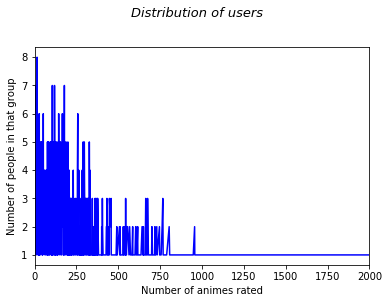

In [95]:
#Creating the plots so we can gather information about the distribution of ratings in the sample
plt.suptitle("Distribution of users", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('animes_rated', 'group_size', data = UserRatedsAggregated, color = 'blue')
plt.xlabel('Number of animes rated')
plt.ylabel('Number of people in that group')
plt.xlim(left = 0, right = 2000)
plt.show()

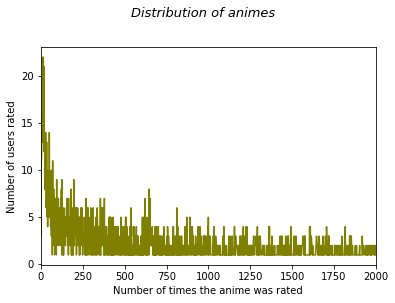

In [97]:
#Creating the plots so we can gather information about the distribution of ratings in the sample
plt.suptitle("Distribution of animes", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('number_of_users', 'group_size', data = AnimeRatedsAggregated, color = 'olive')
plt.xlabel('Number of users rated')
plt.ylabel('Number of animes in that group')
plt.xlim(left = 0, right = 2000)
plt.show()

Here we create another dataframe which contains only users and animes that have at least 10 interactions. We then combine this data by merging our initial frame with the RatedsPerUser and the RatedsPerAnime. 

The reason for this is trying to solve a problem that Recommender Systems commonly runs in to, that is the 'Cold Start Problem'. It is really hard to recommend something to a customer that you do not have data about, but there are several ways to deal with it, such as a Popularity Recommender (where I'll recommend to my new users the most liked products) and other stuff, but I'll just exclude them from my analysis since I already have a lot of data.

In [17]:
#Creating a dataframe of users  and animes with more than 10 interactions
UserRatedsCutten = RatedsPerUser[RatedsPerUser['animes_rated'] >= 10]
AnimeRatedsCutten = RatedsPerAnime[RatedsPerAnime['number_of_users'] >= 10]
#Joining (merging) our new dataframes with the interactions one (this will already deal with the sample problem,
#as it is an inner join). The "HotStart" name comes from a pun about solving the "Cold Start" issue
ScoresDFHotStart = pd.merge(ScoresDF, UserRatedsCutten, left_on = 'username', right_on = 'username', how = 'inner')
ScoresDFHotStart = pd.merge(ScoresDFHotStart, AnimeRatedsCutten, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')

Another info that would be interesting to know is how are the user scores distributed. That could explain us what number represents something that the user liked or not (and will be used later on as a treshold too).

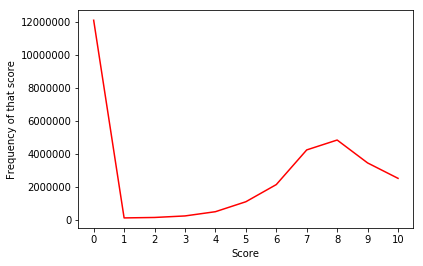

In [18]:
#Grouping the different scores and resetting the index (so the series could become a DF again) 
AnimeRates = ScoresDF['my_score'].value_counts().reset_index().sort_values('index')
plt.plot('index', 'my_score', data = AnimeRates, color = 'red')
plt.xticks(np.arange(11))
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.xlabel('Score')
plt.ylabel('Frequency of that score')
plt.show()

Here we can imply being that the data has a peak at the score of number '7', probably when someone really likes a show it rates them at that minimum. Interesting to see too that we have a lot of rated '0', Otakus are really demanding apparently.

In [100]:
#Just for the record, lets see the difference in numbers between our initial DF and the sampled and cleaned one

print('The initial dataframe has {0} registers and the sampled one has {1} rows.'.format(ScoresDF['username'].count(), ScoresDFHotStart['username'].count()))

The initial dataframe has 31283787 registers and the sampled one has 323047 rows.


# 

# Algorithm metrics

There is a lot of stuff we can rely on to know if our algorithm is having a good performance or not. I'll try to explain some of them briefly and which one I prefer for this specific case.

### Root Mean Squared Error (RMSE)


In [101]:
def precision_recall_at_k(predictions, k=10, threshold= 7):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    # Predictions: Traz uma lista de 5 campos dentro de uma tupla com as seguintes infos: User_ID, Item_ID, True_ID, Est_ID, Details
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Cria um dicionário com a key relativa a um usuário e dois valores relacionados; a nota estimada e a real.

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k /  n_rel if n_rel != 0 else 1

    return precisions, recalls

In [30]:
reader = sp.Reader(rating_scale=(0, 10))
data = sp.Dataset.load_from_df(ScoresDFHotStart[['username', 'anime_id', 'my_score']], reader)
trainset, testset = sp.train_test_split(data, test_size=.25)
analysis = defaultdict(list)

for algo in [sp.SVD(), sp.SlopeOne(), sp.NMF(), sp.NormalPredictor(), sp.KNNBaseline(), sp.KNNBasic(), sp.KNNWithMeans(), sp.KNNWithZScore(), sp.BaselineOnly(), sp.CoClustering()]:
    start = time.time()    
    algo.fit(trainset)
    predictions = algo.test(testset)

    rmse = sp.accuracy.rmse(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=7)
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)

    analysis[algo] = (rmse, precision_avg, time.time() - start)

print(analysis)

RMSE: 3.4792
RMSE: 3.2303
RMSE: 3.3607
RMSE: 5.0643
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.1933
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.3525
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2136
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2229
Estimating biases using als...
RMSE: 3.2230
RMSE: 3.2745
defaultdict(<class 'list'>, {<surprise.prediction_algorithms.matrix_factorization.SVD object at 0xabf098748>: (3.479201697113249, 0.7599646423260175, 21.53566288948059), <surprise.prediction_algorithms.slope_one.SlopeOne object at 0xabf098390>: (3.230288068251265, 0.9014844911833426, 54.692967891693115), <surprise.prediction_algorithms.matrix_factorization.NMF object at 0xabf0984e0>: (3.3606881354198737, 0.8288969316215958, 19.459085941314697), <surprise.prediction_algorithms.random_pred.NormalPredictor object 

In [31]:
analysis_df = pd.DataFrame.from_dict(analysis, orient = 'index', columns = ['RMSE', 'Precision@10', 'Time to run (in seconds)']).reset_index()

analysis_df['Algorithm'] = ['SVD', 'SlopeOne', 'NMF', 'NormalPredictor', 'KNNBaseline', 'KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'BaselineOnly', 'CoClustering']
analysis_df = analysis_df[['Algorithm', 'RMSE', 'Precision@10', 'Time to run (in seconds)']]
analysis_df = analysis_df.sort_values(by=['Precision@10'], ascending = False)
analysis_df['RMSE^-1'] = analysis_df['RMSE'] ** -1
analysis_df.head(n = 15)

,Algorithm,RMSE,Precision@10,Time to run (in seconds),RMSE^-1
8,BaselineOnly,3.223045,0.920989,1.331789,0.310266
1,SlopeOne,3.230288,0.901484,54.692968,0.309570
4,KNNBaseline,3.193282,0.887923,19.247168,0.313157
6,KNNWithMeans,3.213647,0.882020,16.062656,0.311173
9,CoClustering,3.274484,0.860871,6.910524,0.305392
7,KNNWithZScore,3.222915,0.854146,18.117699,0.310278
2,NMF,3.360688,0.828897,19.459086,0.297558
5,KNNBasic,3.352506,0.814533,16.372685,0.298284
0,SVD,3.479202,0.759965,21.535663,0.287422
3,NormalPredictor,5.064347,0.527862,1.026765,0.197459


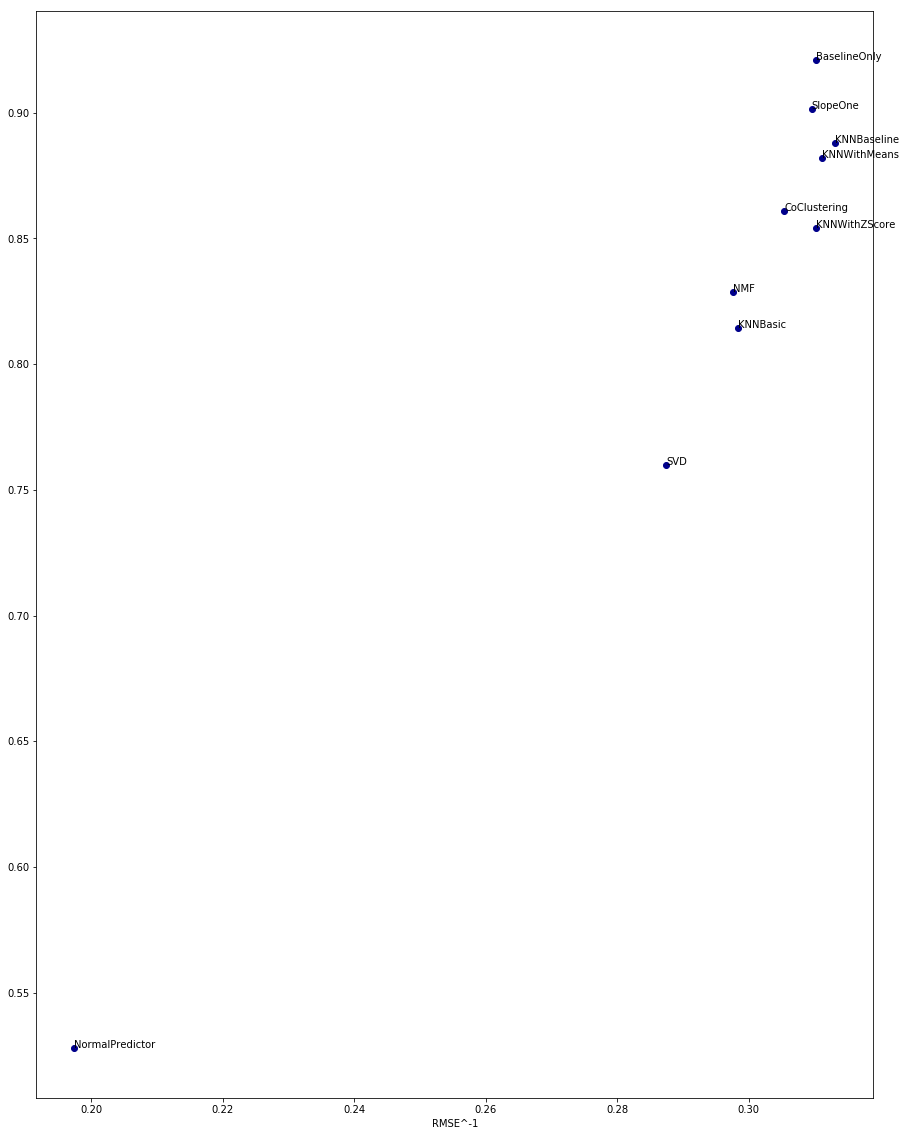

In [32]:
ax = analysis_df.set_index('RMSE^-1')['Precision@10'].plot(style='o', c = 'DarkBlue', figsize = (15, 20))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(analysis_df['RMSE^-1'], analysis_df['Precision@10'], analysis_df['Algorithm'], ax)

In [33]:
trainset = data.build_full_trainset()
algo = sp.BaselineOnly()
algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
last_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
last_predictions.drop('rui', inplace = True, axis = 1)
last_predictions['Iu'] = last_predictions.uid.apply(get_Iu)
last_predictions['Ui'] = last_predictions.iid.apply(get_Ui)

Estimating biases using als...


In [34]:
def bringing_first_n_values(df, uid, n=10):
    df = df[df['uid'] == uid].nlargest(n, 'est')[['uid', 'iid', 'est']]
    df = pd.merge(df, AnimesDF, left_on = 'iid', right_on = 'anime_id', how = 'left')
    return df[['uid', 'est', 'title', 'genre']]

In [37]:
bringing_first_n_values(last_predictions, 'Sirdante')

,uid,est,title,genre
0,Sirdante,9.247170,Shingeki no Kyojin,"Action, Military, Mystery, Super Power, Drama,..."
1,Sirdante,9.005132,Shelter,"Sci-Fi, Music"
2,Sirdante,8.988246,One Punch Man,"Action, Sci-Fi, Comedy, Parody, Super Power, S..."
3,Sirdante,8.933240,Kimi no Na wa.,"Supernatural, Drama, Romance, School"
4,Sirdante,8.819930,Junjou Romantica 2,"Comedy, Drama, Romance, Shounen Ai"
5,Sirdante,8.783053,Majo no Takkyuubin,"Adventure, Comedy, Drama, Magic, Romance, Fantasy"
6,Sirdante,8.663581,Gake no Ue no Ponyo,"Adventure, Fantasy"
7,Sirdante,8.625354,Tonari no Totoro,"Adventure, Comedy, Supernatural"
8,Sirdante,8.587367,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen","Drama, Romance, School, Slice of Life"
9,Sirdante,8.561028,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar..."


In [51]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo_items = sp.KNNBaseline(sim_options=sim_options)
algo_items.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [74]:
def get_item_recommendations(anime_title, anime_id=100000, k=10):
    if anime_id == 100000:     
        anime_id = AnimesDF[AnimesDF['title'] == anime_title]['anime_id'].iloc[0]
        
    iid = algo_items.trainset.to_inner_iid(anime_id)
    neighbors = algo_items.get_neighbors(iid, k=k)
    raw_neighbors = (algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors)
    df = pd.DataFrame(raw_neighbors, columns = ['Anime_ID'])
    df = pd.merge(df, AnimesDF, left_on = 'Anime_ID', right_on = 'anime_id', how = 'left')
    return df[['Anime_ID', 'title', 'genre']]

In [115]:
get_item_recommendations('Steins;Gate', k=30)

,Anime_ID,title,genre
0,10863,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Comedy, Thriller"
1,13601,Psycho-Pass,"Action, Police, Psychological, Sci-Fi"
2,5114,Fullmetal Alchemist: Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
3,9289,Hanasaku Iroha,"Slice of Life, Comedy, Drama"
4,28677,Yamada-kun to 7-nin no Majo (TV),"Harem, Mystery, Comedy, Supernatural, Romance,..."
5,9989,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,"Slice of Life, Supernatural, Drama"
6,11741,Fate/Zero 2nd Season,"Action, Supernatural, Magic, Fantasy"
7,10162,Usagi Drop,"Josei, Slice of Life"
8,11577,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Drama"
9,4382,Suzumiya Haruhi no Yuuutsu (2009),"Sci-Fi, Slice of Life, Mystery, Comedy, Parody..."
